In [1]:
%load_ext autoreload
%autoreload 2
import warnings; warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline
# Python standard library
import os
import json
import requests
from typing import List, Dict, Tuple, Optional

# Numeric/scientific Python etc.
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm

In [3]:
# Set the eGSIM URL to get the ground motion residuals
egsim_url_residuals = "https://egsim.gfz-potsdam.de/query/residuals"


def pretty_print(json_data):
    """Clean print of the json content
    """
    print(json.dumps(json_data, indent=2))
    return


def get_residuals_from_egsim(
    flatfile_path: str,
    gmms: List,
    imts: List,
    plot_type: str,
    query_string: str = ""
) -> Dict:
    """Retreive the residuals for the flatfile and the selected
    set of ground motion models and intensity measure types

    Args:
        flatfile_path: Local path to the selected flatfile
        gmms: List of ground motion models (OpenQuake class names)
        imts: List of intensity measure types (e.g. PGA, PGV, SA(0.1) etc.)
        plot_type: Column to return for x-values (e.g. mag, rrup, etc)
        query_string: Selection query to apply to the data

    Returns:
        json_response: Response of the POST request in json form (if successful)
                       or the response class (if unsuccessful)
    """ 
    with open(flatfile_path, "rb") as flatfile4egsim:
        json_response = None
        # Provide the set of files
        files = {"flatfile": flatfile4egsim}

        # Retreive residuals for a given plot type
        parameters = {"model": gmms, "imt": imts, "plot": plot_type}
        if query_string:
            parameters["data-query"] = query_string
        try:
            # POST request for eGSIM
            response = requests.post(
                egsim_url_residuals,
                files=files,
                data=parameters
            )
            json_response = response.json()
            response.raise_for_status()
        except:
            print("Response failed - see status message")
            raise        
    return json_response

# Could I analyse a single earthquake shortly after an event?

## Exploring Observed Ground Motions from the Kahramanmara&#351; Earthquake

Ground motion data taken from ESM (<https://esm-db.eu/#/home> - Accessed 23/06/2023), selecting all records **not** flagged as poor quality.

Only events with 3 or more good quality records are selected

**Table 1: Events selected for analysis**

|  event_id  | event_time  | event_longitude | event_latitude | event_depth | Mw | Num. Rec. |
| ---------- | ----------- | --------------- | -------------- | ----------- | --------- | --------- |
| INT-20230206_0000008 | 2023-02-06T01:17:36.0 |37.08 | 37.17 | 20.0 | 7.83 | 289 |
| INT-20230206_0000011 | 2023-02-06T01:28:19.0 |36.81 | 37.13 | 40.0 | 6.70 | 22 |
| INT-20230206_0000222 | 2023-02-06T10:24:49.0 |37.24 | 38.11 | 10.0 | 7.55 | 305 |
| INT-20230207_0000338 | 2023-02-07T18:09:59.0 |36.63 | 38.10 | 5.0  | 5.30 | 4 |
| INT-20230216_0000171 | 2023-02-16T11:16:24.0 |35.81 | 36.00 | 10.0 | 4.80 | 3 |
| INT-20230325_0000052 | 2023-03-25T04:39:32.0 |37.02 | 38.07 | 7.0  | 4.50 | 4 |
| INT-20230307_0000202 | 2023-03-07T14:18:22.0 |37.46 | 38.80 | 5.0  | 4.20 | 3 |
| INT-20230307_0000111 | 2023-03-07T09:40:11.0 |36.58 | 37.72 | 5.0  | 4.40 | 4 |
| INT-20230324_0000010 | 2023-03-24T00:39:55.0 |36.40 | 38.02 | 5.0  | 4.60 | 5 |
| INT-20230324_0000175 | 2023-03-24T13:10:34.0 |37.55 | 38.01 | 7.0  | 4.40 | 3 |
| INT-20230521_0000127 | 2023-05-21T12:46:15.0 |36.32 | 37.88 | 5.0  | 5.00 | 4 |


For the two largest events, (\\( M_W \\) 7.83 and \\( M_W \\) 7.55), the multi-segment rupture models are taken from the USGS Shakemap. For all other ruptures a single segment rupture is assumed with the following properties:

* Strike, dip and rake taken from the preferred nodal plane

* Hypocentre in the centre of the fault plane

* Length / Width ratio fixed to 1.25

* Rupture area scaled from magnitude according to the scaling relation of Leonard (2014) Interplate

**Ground motion PGA, PGV and SA(T) are given in terms of RotD50**


In [4]:
# Load in and view the flatfile
data_path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "data", "flatfiles")
flatfile_path = os.path.join(data_path, "example_flatfile_2023_RotD50.csv")
flatfile = pd.read_csv(flatfile_path, sep=",",)
flatfile

,gmid,event_id,event_time,event_longitude,event_latitude,event_depth,magnitude,strike,dip,rake,...,SA(5.500),SA(6.000),SA(6.500),SA(7.000),SA(7.500),SA(8.000),SA(8.500),SA(9.000),SA(9.500),SA(10.000)
0,INT-20230206_0000008|KO-TUNC|HN,INT-20230206_0000008,2023-02-06T01:17:36.000000Z,37.08,37.17,20.0,7.83,41.563938,80.96893,-1.0,...,0.016487,0.014861,0.014393,0.011889,0.012162,0.012471,0.014036,0.014549,1.463535e-02,1.462333e-02
1,INT-20230206_0000008|TK-0118|HN,INT-20230206_0000008,2023-02-06T01:17:36.000000Z,37.08,37.17,20.0,7.83,41.563938,80.96893,-1.0,...,0.036545,0.029734,0.031675,0.029825,0.027148,0.024118,0.022191,0.019858,1.969109e-02,1.908152e-02
2,INT-20230206_0000008|TK-0119|HN,INT-20230206_0000008,2023-02-06T01:17:36.000000Z,37.08,37.17,20.0,7.83,41.563938,80.96893,-1.0,...,0.020589,0.020201,0.024237,0.023534,0.020944,0.020848,0.022582,0.023533,2.346984e-02,2.272238e-02
3,INT-20230206_0000008|TK-0122|HN,INT-20230206_0000008,2023-02-06T01:17:36.000000Z,37.08,37.17,20.0,7.83,41.563938,80.96893,-1.0,...,0.013690,0.016388,0.015815,0.013882,0.011818,0.010670,0.010296,0.010078,9.312330e-03,8.556686e-03
4,INT-20230206_0000008|TK-0123|HN,INT-20230206_0000008,2023-02-06T01:17:36.000000Z,37.08,37.17,20.0,7.83,41.563938,80.96893,-1.0,...,0.042793,0.033323,0.036449,0.031333,0.027435,0.027360,0.027831,0.025207,2.419771e-02,2.276834e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
533,INT-20230324_0000175|KO-TUNC|HN,INT-20230324_0000175,2023-03-24T13:10:34.000000Z,37.55,38.01,7.0,4.40,347.000000,87.00000,179.0,...,0.000004,0.000003,0.000002,0.000002,0.000002,0.000001,0.000001,0.000001,9.020376e-07,7.361859e-07
534,INT-20230521_0000127|KO-ARPRA|HN,INT-20230521_0000127,2023-05-21T12:46:15.000000Z,36.32,37.88,5.0,5.00,218.000000,51.00000,-86.0,...,0.000015,0.000014,0.000014,0.000012,0.000008,0.000006,0.000005,0.000005,4.427773e-06,3.845050e-06
535,INT-20230521_0000127|KO-CMRD|HN,INT-20230521_0000127,2023-05-21T12:46:15.000000Z,36.32,37.88,5.0,5.00,218.000000,51.00000,-86.0,...,0.000017,0.000014,0.000011,0.000011,0.000010,0.000008,0.000007,0.000005,4.476359e-06,3.768438e-06
536,INT-20230521_0000127|KO-KHMN|HN,INT-20230521_0000127,2023-05-21T12:46:15.000000Z,36.32,37.88,5.0,5.00,218.000000,51.00000,-86.0,...,0.000032,0.000030,0.000025,0.000018,0.000013,0.000011,0.000010,0.000008,6.474296e-06,5.509096e-06


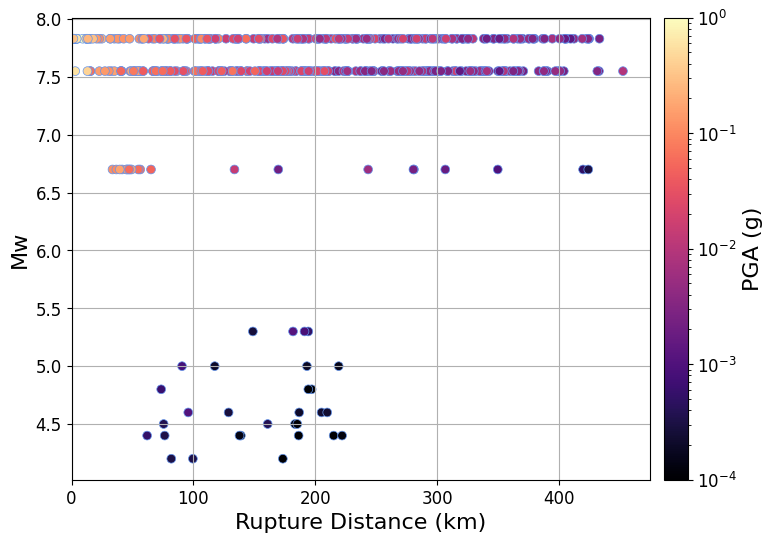

In [5]:
# Plot Magnitude, Distance and PGA
fig, ax = plt.subplots(1, 1, figsize=(9,6))
cax = ax.scatter(
    flatfile["rrup"], flatfile["magnitude"], c=flatfile["PGA"],
    cmap='magma', norm=LogNorm(1.0E-4, 1.0),
    edgecolor="cornflowerblue", linewidth=0.5, s=40
)

# Control and annotate axes
ax.set_xlabel("Rupture Distance (km)", fontsize=16)
ax.set_ylabel("Mw", fontsize=16)
ax.set_xlim(0)
ax.grid(which="both")
ax.tick_params(labelsize=12)

# Add colorbar for PGA
cbar = fig.colorbar(cax, pad=0.02)
cbar.ax.set_ylabel("PGA (g)", fontsize=16)
cbar.ax.tick_params(labelsize=12)

In [6]:
# Select a few GMMs to compare
gmms = [
    "AkkarEtAlRjb2014",  # European & Middle East (RESORCE)
    "CauzziEtAl2014",  # Global (Japan)
    "ChiouYoungs2014",  # Global (NGA West 2)
    "KothaEtAl2020ESHM20"  # Backbone GMM from ESHM20
]

# Select some IMTs
imts = ["PGV", "PGA", "SA(0.2)", "SA(2.0)"]

##### Plot the between-event residuals $\delta B_e$ with respect to magnitude

In [7]:
all_residuals_mag = get_residuals_from_egsim(
    flatfile_path,  # Path to the flatfile
    gmms=gmms,  # List of GMMs
    imts=imts,  # List of IMTs
    plot_type="mag"
)
print(list(all_residuals_mag))
print(list(all_residuals_mag["PGA"]))
print(list(all_residuals_mag["PGA"]["Inter event"]))
all_residuals_mag["PGA"]["Inter event"]["AkkarEtAlRjb2014"]

['PGV', 'PGA', 'SA(0.2)', 'SA(2.0)']
['Inter event', 'Total', 'Intra event']
['AkkarEtAlRjb2014', 'CauzziEtAl2014', 'ChiouYoungs2014', 'KothaEtAl2020ESHM20']


{'slope': 0.1855316442115419,
 'intercept': -2.7518276769790275,
 'pvalue': 0.2777869167636896,
 'xlabel': 'Magnitude',
 'ylabel': 'Z (PGA)',
 'mean': None,
 'stddev': None,
 'median': None,
 'xvalues': [7.83, 6.7, 7.55, 5.3, 4.8, 4.4, 4.2, 4.6, 4.4, 4.5, 5.0],
 'yvalues': [-1.546867806565824,
  -0.6453139131410983,
  -1.6618789746483762,
  -1.0995161211243183,
  -2.919897825224684,
  -2.2414481585462975,
  -1.2968704926655918,
  -1.1249967118824697,
  -2.03211270024148,
  -2.360559627300308,
  -2.3423262465686485]}

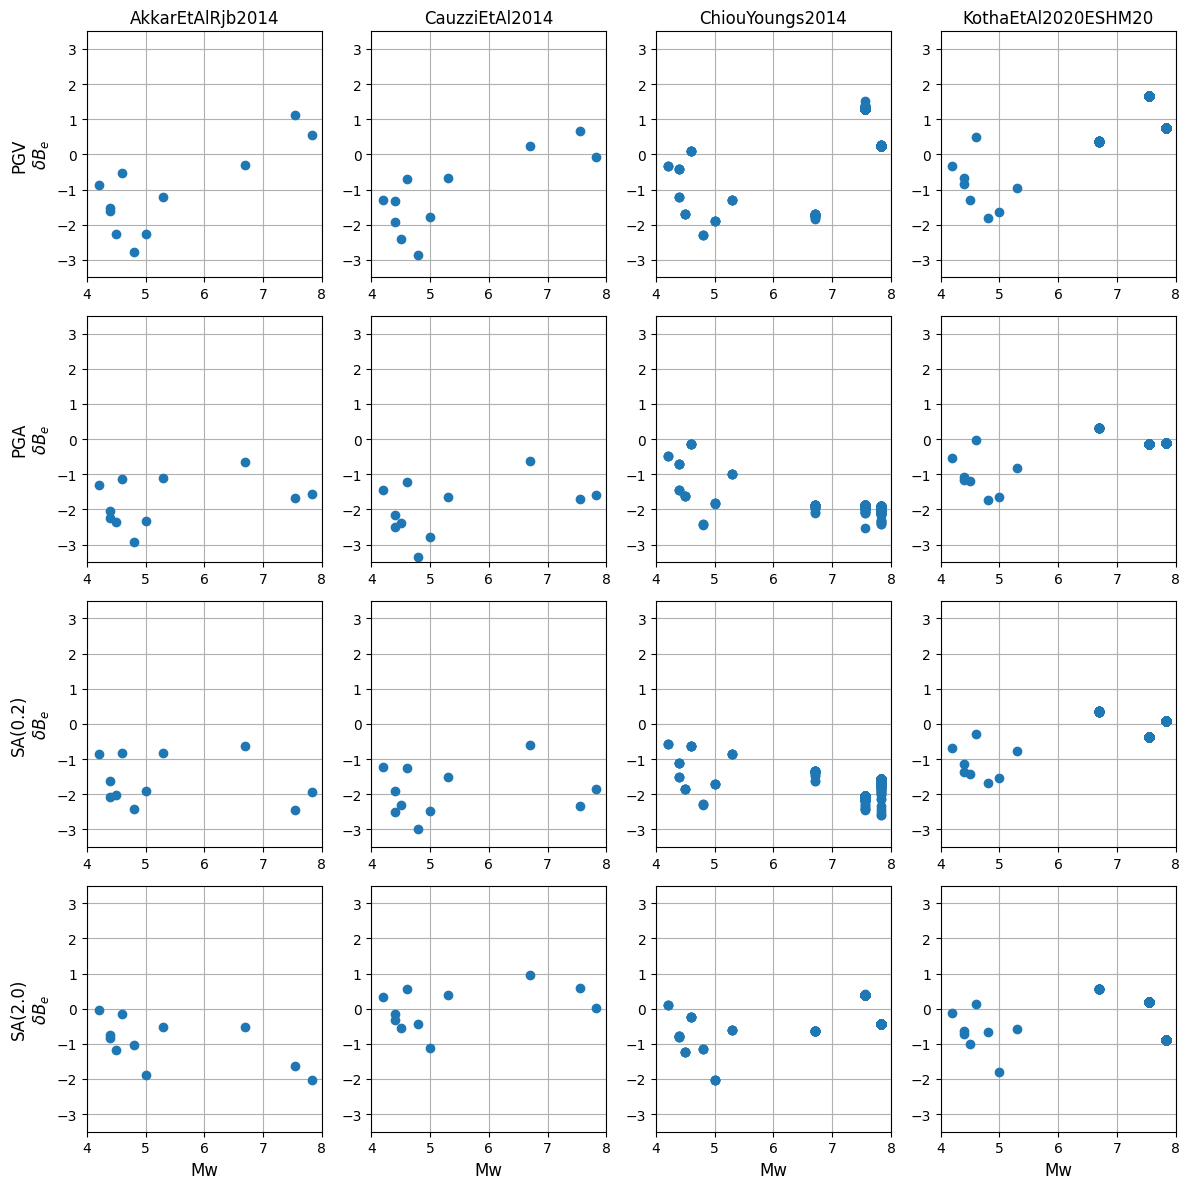

In [8]:
 
fig, axs = plt.subplots(len(imts), len(gmms), figsize=(12,12))
for i, gmm in enumerate(gmms):
    for j, imt in enumerate(imts):
        # Plot ESM between event residuals
        axs[j, i].plot(all_residuals_mag[imt]["Inter event"][gmm]["xvalues"],
                       all_residuals_mag[imt]["Inter event"][gmm]["yvalues"],
                       "o", color="tab:blue",)
        # Labelling
        if not i:
            axs[j, i].set_ylabel(imt + "\n" + r"$\delta B_e$", fontsize=12)
        if not j:
            axs[j, i].set_title(gmm, fontsize=12)
        if j == (len(imts) - 1):
            axs[j, i].set_xlabel("Mw", fontsize=12)

# Axis formatting
for ax in axs.flatten():
    ax.set_xlim(4.0, 8.0)
    ax.set_ylim(-3.5, 3.5)
    ax.set_xticks(np.arange(4.0, 9.0, 1.0))
    ax.grid(which="both")
fig.tight_layout()

### How does $\delta B_e$ change with period for the Mw 7.8 mainshock?

Consider a range of periods  between 0.02 s and 4.0 s (plus PGV and PGA)

In [9]:
periods = np.logspace(np.log10(0.02), np.log10(4.0), 20)
extended_imts = ["PGV", "PGA"] + [f"SA({per})" for per in periods]
extended_imts

['PGV',
 'PGA',
 'SA(0.020000000000000004)',
 'SA(0.026432414588672085)',
 'SA(0.03493362704937226)',
 'SA(0.04616900566275285)',
 'SA(0.061017914941231655)',
 'SA(0.0806425412531482)',
 'SA(0.10657885419436522)',
 'SA(0.14085682302255476)',
 'SA(0.18615929718876892)',
 'SA(0.24603198614146787)',
 'SA(0.32516097298828534)',
 'SA(0.4297394823041181)',
 'SA(0.567952608069188)',
 'SA(0.7506179401601185)',
 'SA(0.9920322296003653)',
 'SA(1.31109035890608)',
 'SA(1.7327641964908194)',
 'SA(2.290057081302631)',
 'SA(3.026586910235772)',
 'SA(4.0)']

### Now we can call eGSIM again but filter our query to just the mainshock (by event ID)

In [10]:
all_residuals_mainshock = get_residuals_from_egsim(
    flatfile_path,
    gmms=gmms,
    imts=extended_imts,
    plot_type="mag",
    query_string="event_id=='INT-20230206_0000008'"
)

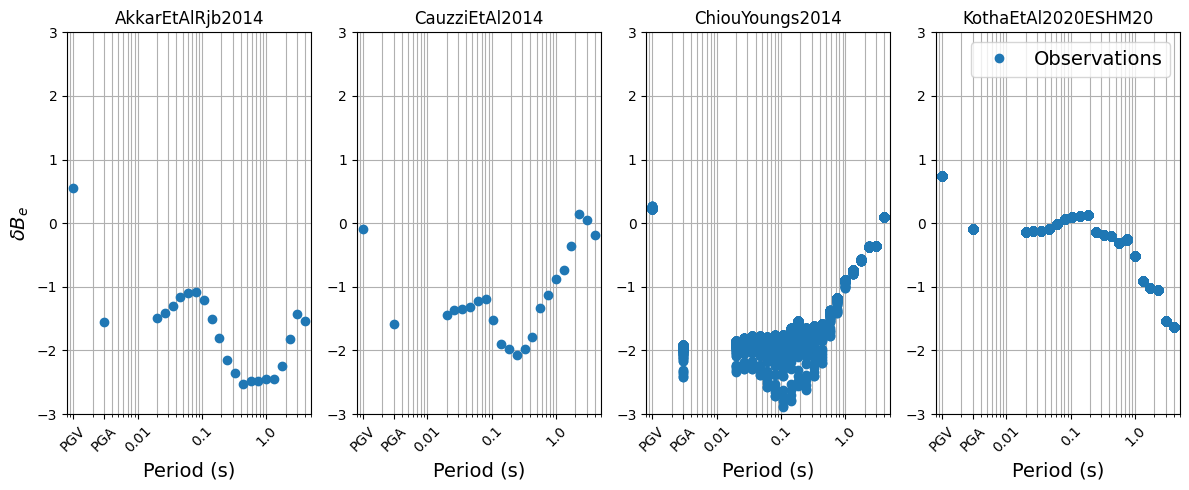

In [11]:
fig, axs = plt.subplots(1, len(gmms), figsize=(12,5))
lines = []
for i, gmm in enumerate(gmms):
    for j, imt in enumerate(extended_imts):
        # Get dBe for the period (IMT)
        yvalues = all_residuals_mainshock[imt]["Inter event"][gmm]["yvalues"]
        # Set the x-label position corresponding to the IMT
        if imt == "PGV":
            period = 0.001
        elif imt == "PGA":
            period = 0.003
        else:
            period = float(imt.replace("SA(", "").replace(")", ""))

        xvalues = [period] * len(yvalues)
        # Plot ESM between-event residuals    
        line1 = axs[i].plot(xvalues, yvalues,
                           "o", color="tab:blue",
                            label="Observations")
        lines.extend(line1)
    axs[i].set_title(gmm, fontsize=12)

axs[0].set_ylabel(""r"$\delta B_e$", fontsize=14)    
axs[-1].legend(handles=lines[-1:], loc="upper right", fontsize=14)
# Clean and harmonise the axes
for ax in axs.flatten():
    ax.set_xscale("log")
    ax.set_xlim(8.0E-4, 5)
    ax.set_ylim(-3, 3)
    ax.set_xlabel("Period (s)", fontsize=14)
    ax.set_xticks([0.001, 0.003, 0.01, 0.1, 1.0],
                  ["PGV", "PGA", "0.01", "0.1", "1.0", ],)
    ax.tick_params(axis="x", rotation=45)
    ax.grid(which="both")
fig.tight_layout()

##### Are the trends persistent for the second shock?

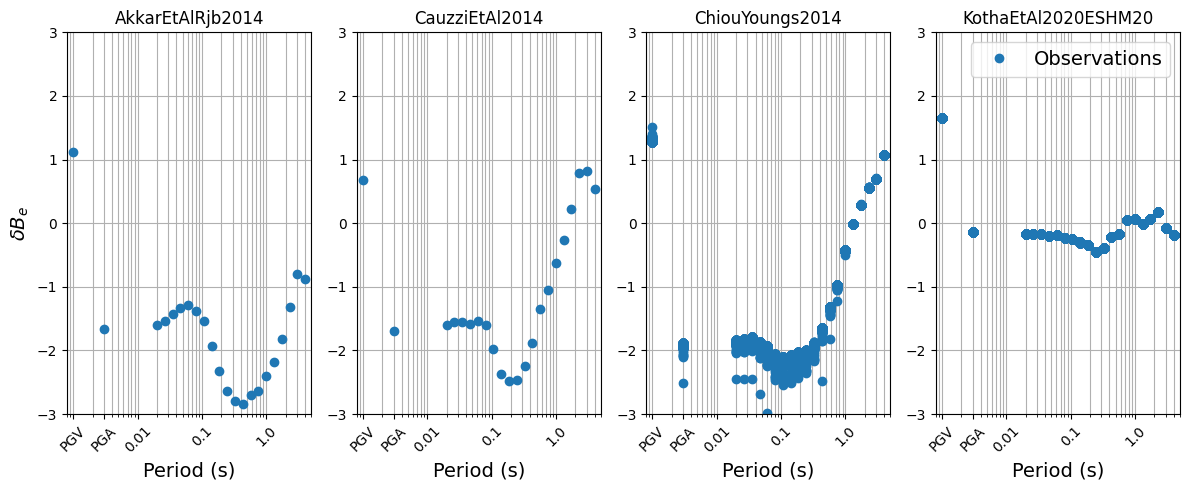

In [12]:
all_residuals_2nd_mainshock = get_residuals_from_egsim(
    flatfile_path,
    gmms=gmms,
    imts=extended_imts,
    plot_type="mag",
    query_string="event_id=='INT-20230206_0000222'"
)

fig, axs = plt.subplots(1, len(gmms), figsize=(12,5))
lines = []
for i, gmm in enumerate(gmms):
    for j, imt in enumerate(extended_imts):
        # Get dBe for the period (IMT)
        yvalues = all_residuals_2nd_mainshock[imt]["Inter event"][gmm]["yvalues"]
        # Set the x-label position corresponding to the IMT
        if imt == "PGV":
            period = 0.001
        elif imt == "PGA":
            period = 0.003
        else:
            period = float(imt.replace("SA(", "").replace(")", ""))

        xvalues = [period] * len(yvalues)
        # Plot ESM between-event residuals    
        line1 = axs[i].plot(xvalues, yvalues,
                           "o", color="tab:blue",
                            label="Observations")
        lines.extend(line1)
    axs[i].set_title(gmm, fontsize=12)

axs[0].set_ylabel(""r"$\delta B_e$", fontsize=14)    
axs[-1].legend(handles=lines[-1:], loc="upper right", fontsize=14)
# Clean and harmonise the axes
for ax in axs.flatten():
    ax.set_xscale("log")
    ax.set_xlim(8.0E-4, 5)
    ax.set_ylim(-3, 3)
    ax.set_xlabel("Period (s)", fontsize=14)
    ax.set_xticks([0.001, 0.003, 0.01, 0.1, 1.0],
                  ["PGV", "PGA", "0.01", "0.1", "1.0", ],)
    ax.tick_params(axis="x", rotation=45)
    ax.grid(which="both")
fig.tight_layout()

### What about the within-event residuals $\delta W_{es}$ for the two mainshocks?

How well are we capturing the attenuation from the two mainshocks?

In [13]:
# Just look at the two mainshocks
residuals_dists = get_residuals_from_egsim(
    flatfile_path,
    gmms=gmms,
    imts=imts,
    plot_type="rrup",
    query_string="(event_id=='INT-20230206_0000008')|(event_id=='INT-20230206_0000222')"
)


Perhaps we can use a more sophisticated data exploration/visualisation tool ...

... Let's switch to Seaborn (https://seaborn.pydata.org/index.html)

For this, however, we need to convert our data from json dictionary formats into pandas Dataframes


In [14]:
import seaborn as sns

# For seaborn we can we must render our data into a Pandas Dataframe
def json_to_dataframe(
    dataset: Dict,
    gmms: Dict,
    imts: List,
    xvalue_name: str,
    label: Optional[str] = None
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Converts the results of an eGSIM query from a json dict
    to separate dataframes for between-event, within-event and
    total residuals

    Args:
        dataset: eGSIM query output
        gmms: Dictionary mapping a GMM name to an abberviation,
              e.g. {"AkkarEtAlRjb2014", "Ak2014", "KothaEtAl2020ESHM20": "ESHM20" etc.}
        imts: List of intensity measure types
        xvalue_name: Name for the column to be used for the x-values
        label: If specified, then adds a column indicating a label for the
               data type

    Returns:
        dbe: Between-event residuals as a pandas Dataframe
        dwes: Within-event residuals as a pandas Dataframe
        dtot: Total residuals as a pandas DataFrame
    """
    dbe = {
        xvalue_name: [],
        "imt": [],
        "gmm": [],   
        "dbe": []
    }
    dwes = {
        xvalue_name: [],
        "imt": [],   
        "gmm": [],
        "dwes": []
    }
    dtot = {
        xvalue_name: [],
        "imt": [],
        "gmm": [],
        "dtot": []
    }
    for gmm, gmm_abbr in gmms.items():
        for imt in imts:
            # Get lengths of vectors
            nbe = len(dataset[imt]["Inter event"][gmm]["xvalues"])
            nwes = len(dataset[imt]["Intra event"][gmm]["xvalues"])
            ntot = len(dataset[imt]["Total"][gmm]["xvalues"])
            # Between event data
            dbe[xvalue_name].extend(dataset[imt]["Inter event"][gmm]["xvalues"])
            dbe["imt"].extend([imt] * nbe)
            dbe["gmm"].extend([gmm_abbr] * nbe)
            dbe["dbe"].extend(dataset[imt]["Inter event"][gmm]["yvalues"])
            # Within-event data
            dwes[xvalue_name].extend(dataset[imt]["Intra event"][gmm]["xvalues"])
            dwes["imt"].extend([imt] * nwes)
            dwes["gmm"].extend([gmm_abbr] * nwes)
            dwes["dwes"].extend(dataset[imt]["Intra event"][gmm]["yvalues"])       
            # Total residual
            dtot[xvalue_name].extend(dataset[imt]["Total"][gmm]["xvalues"])
            dtot["imt"].extend([imt] * ntot)
            dtot["gmm"].extend([gmm_abbr] * ntot)
            dtot["dtot"].extend(dataset[imt]["Total"][gmm]["yvalues"])
    if label is not None:
        dbe["type"] = [label] * len(dbe["dbe"])
        dwes["type"] = [label] * len(dwes["dwes"])
        dtot["type"] = [label] * len(dtot["dtot"])
    return pd.DataFrame(dbe), pd.DataFrame(dwes), pd.DataFrame(dtot)

In [15]:
# Map the OpenQuake name to a shorter abbreviation
gmm_mapping = {
    "AkkarEtAlRjb2014": "Ak2014",  # European & Middle East (RESORCE)
    "CauzziEtAl2014": "Ca2015",  # Global (Japan)
    "ChiouYoungs2014": "CY2014",  # Global (NGA West 2)
    "KothaEtAl2020ESHM20": "ESHM20"  # Backbone GMM from ESHM20
}

# Get the between-event, within-event and total residuals
# as dataframes
dbe, dwes, dtot = json_to_dataframe(
    residuals_dists,  # Residuals
    gmm_mapping,  # GMM naming map
    imts,  # Intensity measure type
    "rrup",  # Value for column on x-axis
)
dwes

,rrup,imt,gmm,dwes
0,191.484326,PGV,Ak2014,0.643025
1,106.072663,PGV,Ak2014,1.918478
2,78.670919,PGV,Ak2014,0.512307
3,84.150669,PGV,Ak2014,-0.084578
4,102.515393,PGV,Ak2014,1.385512
...,...,...,...,...
7771,160.336176,SA(2.0),ESHM20,-0.428970
7772,226.403948,SA(2.0),ESHM20,-0.225988
7773,194.663857,SA(2.0),ESHM20,0.728001
7774,169.464479,SA(2.0),ESHM20,-0.125974


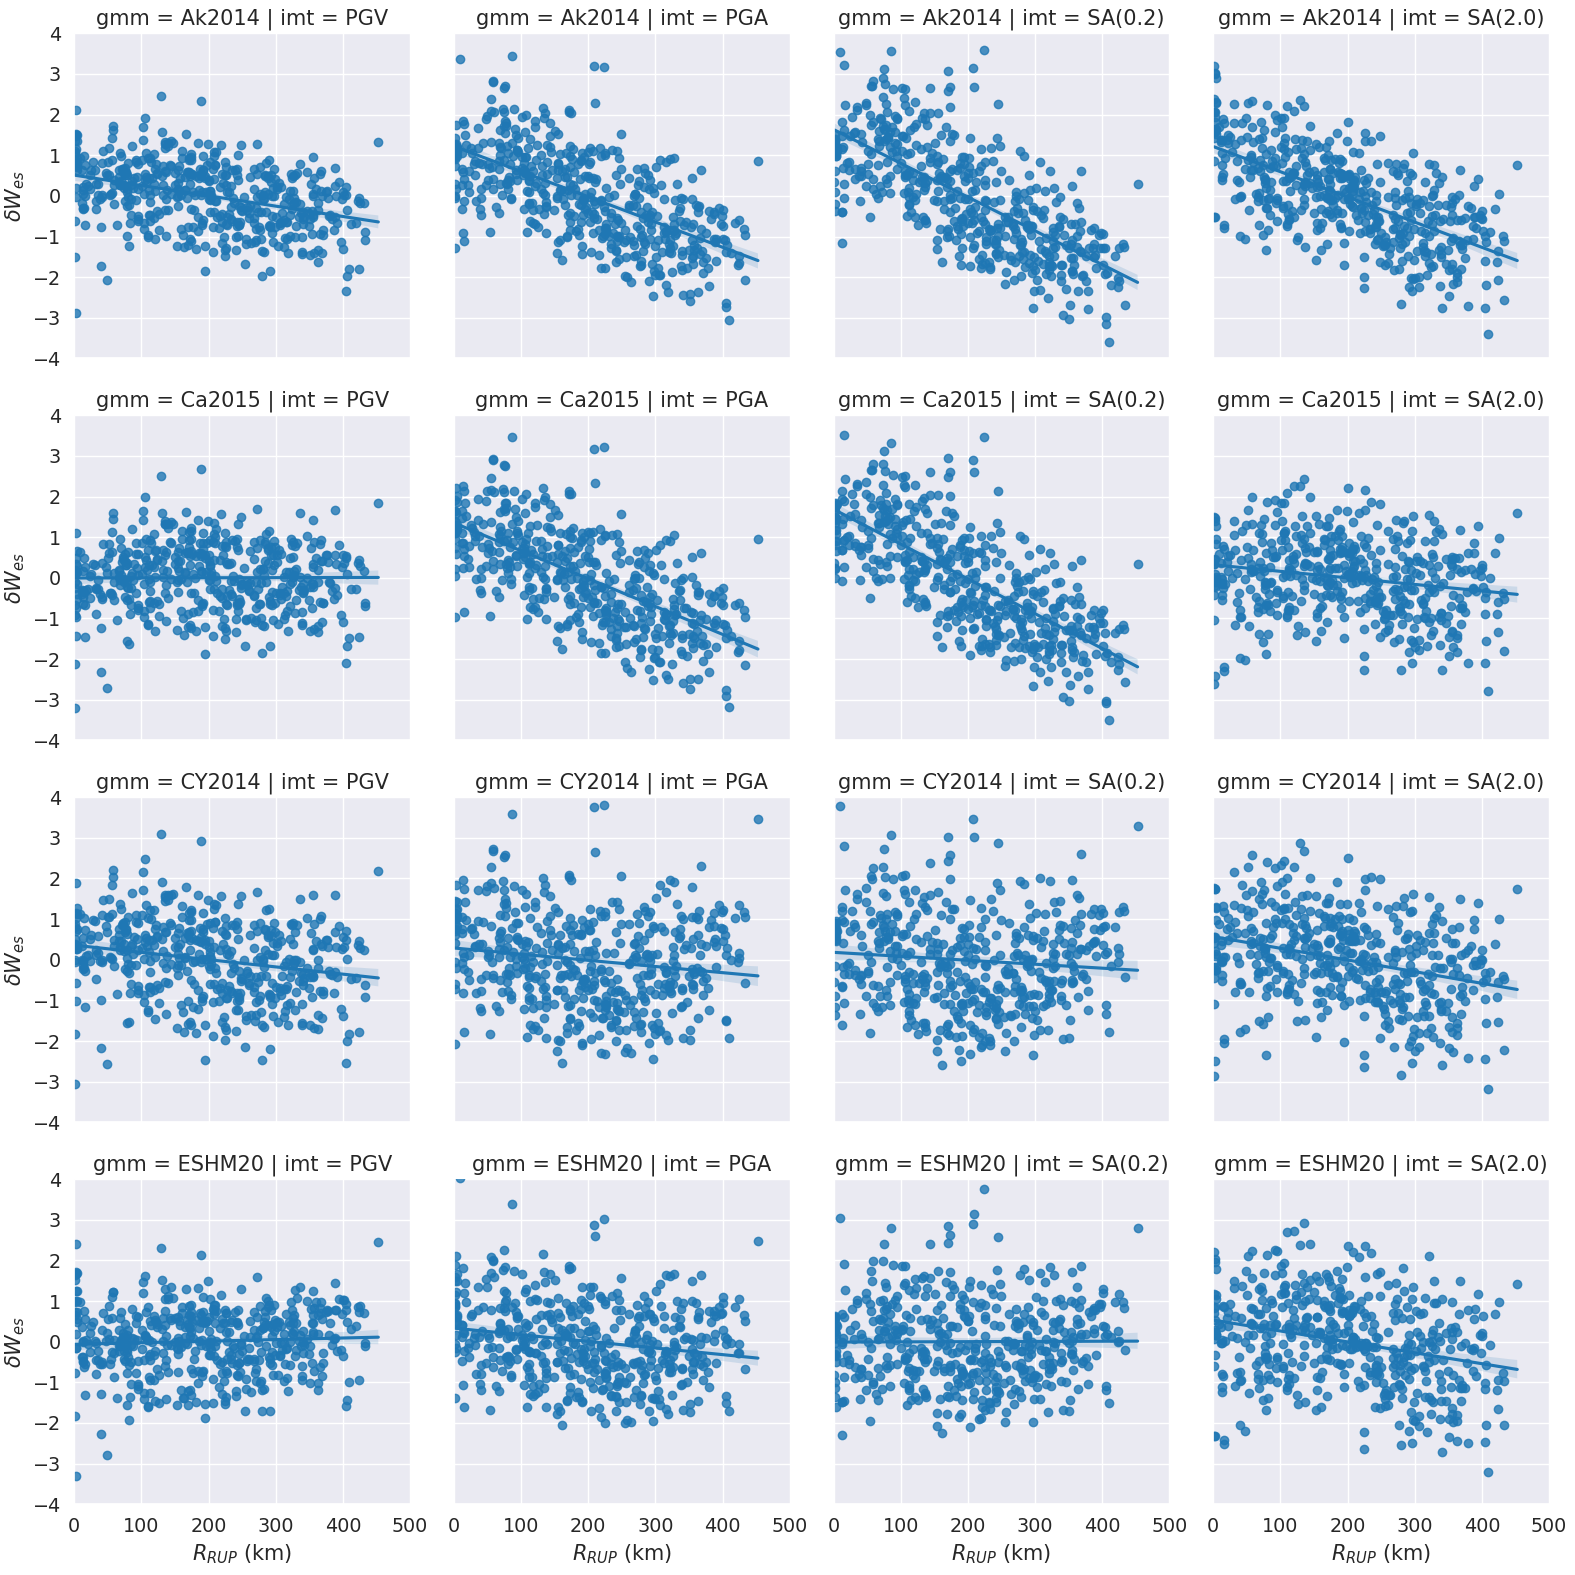

In [16]:
# Linear model plot with seaborn
with sns.axes_style("darkgrid"):
    sns.set_context("notebook", font_scale=1.25)
    # Plot with a linear model fit
    fgrid = sns.lmplot(x="rrup", y="dwes",
                       col="imt", row="gmm", data=dwes, height=4)
    # Control and label axes
    fgrid.set(ylim=(-4, 4.),  xlim=(0, 500))
    fgrid.set_axis_labels(r"$R_{RUP}$ (km)", r"$\delta W_{es}$")
    fgrid.tight_layout()

In [17]:
# Get the within-event residuals for each of the two mainshocks
residuals_dists_EQ1 = get_residuals_from_egsim(
    flatfile_path,
    gmms=gmms,
    imts=imts,
    plot_type="rrup",
    query_string="event_id=='INT-20230206_0000008'"
)

residuals_dists_EQ2 = get_residuals_from_egsim(
    flatfile_path,
    gmms=gmms,
    imts=imts,
    plot_type="rrup",
    query_string="event_id=='INT-20230206_0000222'"
)

# Get the mixed-effects residuals for both events
dbe_1, dwes_1, dtot_1 = json_to_dataframe(
    residuals_dists_EQ1,  # Residuals
    gmm_mapping,  # GMM naming map
    imts,  # Intensity measure type
    "rrup",  # Value for column on x-axis
    label="EQ1: Mw 7.8"
)


dbe_2, dwes_2, dtot_2 = json_to_dataframe(
    residuals_dists_EQ2,  # Residuals
    gmm_mapping,  # GMM naming map
    imts,  # Intensity measure type
    "rrup",  # Value for column on x-axis
    label="EQ2: Mw 7.5"
)

# Concatenate the two dataframes
dbe = pd.concat([dbe_1, dbe_2], axis=0)
dwes = pd.concat([dwes_1, dwes_2], axis=0)
dtot = pd.concat([dtot_1, dtot_2], axis=0)

# Show
dtot

,rrup,imt,gmm,dtot,type
0,191.484326,PGV,Ak2014,0.831594,EQ1: Mw 7.8
1,106.072663,PGV,Ak2014,1.948907,EQ1: Mw 7.8
2,78.670919,PGV,Ak2014,0.717083,EQ1: Mw 7.8
3,84.150669,PGV,Ak2014,0.194204,EQ1: Mw 7.8
4,102.515393,PGV,Ak2014,1.482022,EQ1: Mw 7.8
...,...,...,...,...,...
3963,160.336176,SA(2.0),ESHM20,-0.276441,EQ2: Mw 7.5
3964,226.403948,SA(2.0),ESHM20,-0.100376,EQ2: Mw 7.5
3965,194.663857,SA(2.0),ESHM20,0.727104,EQ2: Mw 7.5
3966,169.464479,SA(2.0),ESHM20,-0.013624,EQ2: Mw 7.5


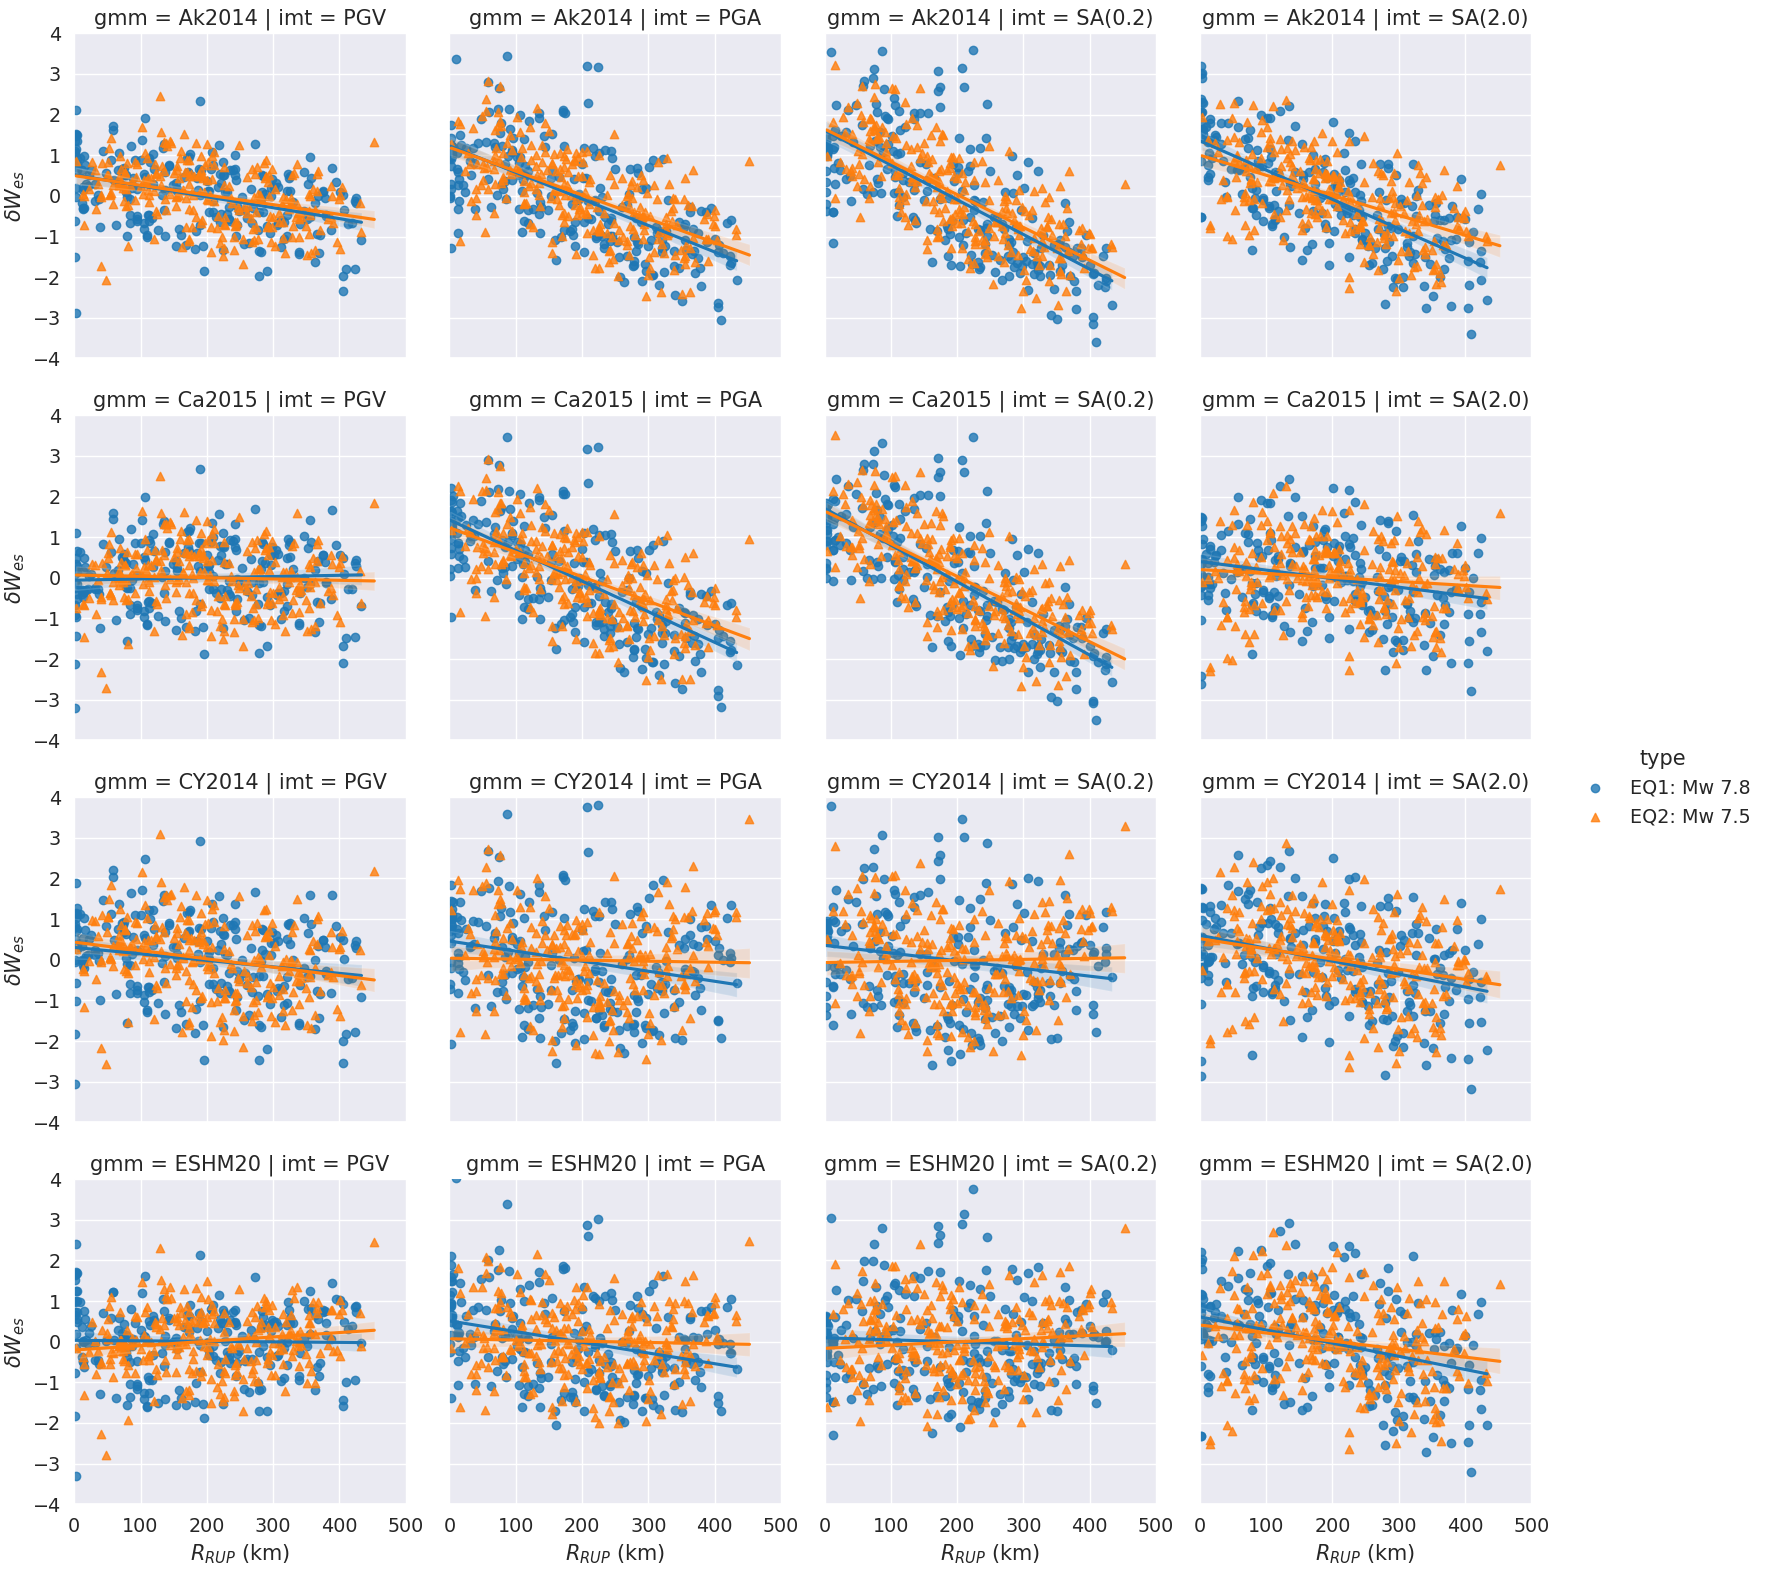

In [18]:
# Linear model plot with seaborn
with sns.axes_style("darkgrid"):
    sns.set_context("notebook", font_scale=1.25)
    # Plot with a linear model fit - separating by the label
    fgrid = sns.lmplot(x="rrup", y="dwes", hue="type", 
                       col="imt", row="gmm", data=dwes,
                       height=4, markers=["o", "^"],)
    # Control and label axes
    #fgrid.set(ylim=(-4, 4.), xscale="log", xlim=(1, 1000))
    fgrid.set(ylim=(-4, 4.), xlim=(0, 500))
    fgrid.set_axis_labels(r"$R_{RUP}$ (km)", r"$\delta W_{es}$")
    fgrid.tight_layout()